In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
d = pd.read_csv("term-deposit-marketing-2020.csv")
print(d.shape)
d.head()

(40000, 14)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
d.y.value_counts()

no     37104
yes     2896
Name: y, dtype: int64

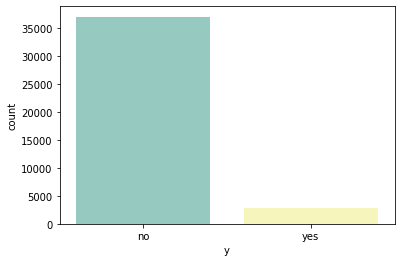

In [32]:
#plt.figure(figsize=(10,5))
sns.countplot(x= "y", data=d, palette="Set3")

##### Target variable is imbalanced

In [29]:
d.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [4]:
d_num = d[['age', 'balance', 'day', 'duration', 'campaign', 'y']]

In [5]:
d_num.head()

,age,balance,day,duration,campaign,y
0,58,2143,5,261,1,no
1,44,29,5,151,1,no
2,33,2,5,76,1,no
3,47,1506,5,92,1,no
4,33,1,5,198,1,no


In [27]:
d.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [8]:
d_num['y'] = d_num.y.map(dict(yes=1, no=0))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
d_num.head()

,age,balance,day,duration,campaign,y
0,58,2143,5,261,1,0
1,44,29,5,151,1,0
2,33,2,5,76,1,0
3,47,1506,5,92,1,0
4,33,1,5,198,1,0


In [10]:
d.y.value_counts()

no     37104
yes     2896
Name: y, dtype: int64

##### running models with just numeric features

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score, auc

In [12]:
# function for Confusion matrix, Classification Report and ROC-Curve

def classif_report(Y_test, Y_pred, pred_prob):
    print("\n", "Confusion Matrix")
    c_matrix = confusion_matrix(Y_test, Y_pred)
    ax = sns.heatmap(c_matrix, square = True,  annot=True, cbar=False, fmt = 'g', cmap="RdBu",   
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    #heatmap getting truncated so added below to extend the plot
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    custom_ylim = (b, t)
    plt.setp(ax, ylim=custom_ylim)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    print("\n", "Classification Report", "\n")
    print(classification_report(Y_test, Y_pred))
    print("Accuracy: ",accuracy_score(Y_test, Y_pred))
    print("Precision Score: ", precision_score(Y_test, Y_pred))
    print("Recall Score: ", recall_score(Y_test, Y_pred))
    print("F1 Score: ", f1_score(Y_test, Y_pred))
    pred_prob_one = pred_prob[:,1]
    fpr, tpr, thresholds = roc_curve(Y_test, pred_prob_one)
    roc_auc = auc(fpr, tpr)
    print("AUC: ", roc_auc)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC Curve (Area = %0.2f)' % roc_auc)
    plt.plot([0.0, 1.0], [0, 1],'r--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC on Test Data')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    print("----------------------------------------------------------------------------------------")
    print("----------------------------------------------------------------------------------------")

In [13]:
Y = d_num['y']
X = d_num.drop('y', axis=1)

In [14]:
#train:test = 0.85:0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.85, random_state = 21, stratify=Y)

In [15]:
print("Train Data Dimensions : ", X_train.shape)
print("Test Data Dimensions : ", X_test.shape)

Train Data Dimensions :  (34000, 5)
Test Data Dimensions :  (6000, 5)


In [25]:
#function to run different models

def model_data(XTr, XTe, YTr, YTe):
    
    print("\n", "Logistic Regression")
    clf_model = LogisticRegression()
    clf_model.fit(XTr, YTr)
    Y_pred = clf_model.predict(XTe)
    pred_prob = clf_model.predict_proba(XTe)
    classif_report(YTe, Y_pred, pred_prob)   
    
#    print("\n", "Naive Bayes")
#    clf_model = MultinomialNB()
#    clf_model.fit(XTr, YTr)
#    Y_pred = clf_model.predict(XTe)
#    pred_prob = clf_model.predict_proba(XTe)
#    classif_report(YTe, Y_pred, pred_prob)
    
    print("\n", "Decision Tree")
    clf_model = DecisionTreeClassifier()
    clf_model.fit(XTr, YTr)
    Y_pred = clf_model.predict(XTe)
    pred_prob = clf_model.predict_proba(XTe)
    classif_report(YTe, Y_pred, pred_prob)    
    
    print("\n", "Random Forest")
    clf_model = RandomForestClassifier()
    clf_model.fit(XTr, YTr)
    Y_pred = clf_model.predict(XTe)
    pred_prob = clf_model.predict_proba(XTe)
    classif_report(YTe, Y_pred, pred_prob)
    
    print("\n", "Gradient Boosting")
    clf_model = GradientBoostingClassifier()
    clf_model.fit(XTr, YTr)
    Y_pred = clf_model.predict(XTe)
    pred_prob = clf_model.predict_proba(XTe)
    classif_report(YTe, Y_pred, pred_prob)   


 Logistic Regression

 Confusion Matrix


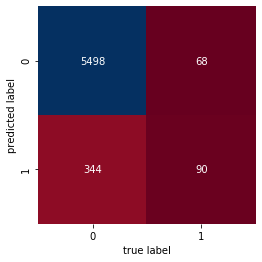


 Classification Report 

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5566
           1       0.57      0.21      0.30       434

    accuracy                           0.93      6000
   macro avg       0.76      0.60      0.63      6000
weighted avg       0.91      0.93      0.92      6000

Accuracy:  0.9313333333333333
Precision Score:  0.569620253164557
Recall Score:  0.2073732718894009
F1 Score:  0.30405405405405406
AUC:  0.8750668558777701


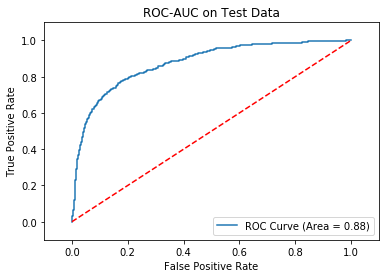

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Decision Tree

 Confusion Matrix


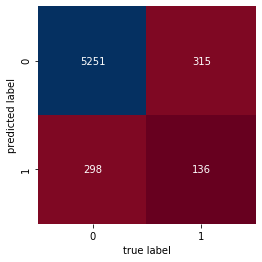


 Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5566
           1       0.30      0.31      0.31       434

    accuracy                           0.90      6000
   macro avg       0.62      0.63      0.63      6000
weighted avg       0.90      0.90      0.90      6000

Accuracy:  0.8978333333333334
Precision Score:  0.30155210643015523
Recall Score:  0.31336405529953915
F1 Score:  0.3073446327683616
AUC:  0.6283852256375525


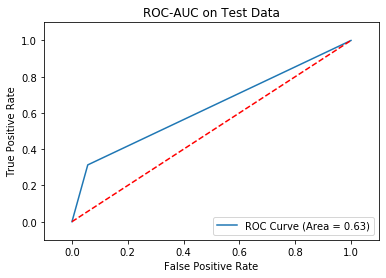

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Random Forest

 Confusion Matrix


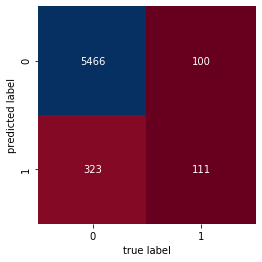


 Classification Report 

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5566
           1       0.53      0.26      0.34       434

    accuracy                           0.93      6000
   macro avg       0.74      0.62      0.65      6000
weighted avg       0.91      0.93      0.92      6000

Accuracy:  0.9295
Precision Score:  0.5260663507109005
Recall Score:  0.2557603686635945
F1 Score:  0.34418604651162793
AUC:  0.8828931332597021


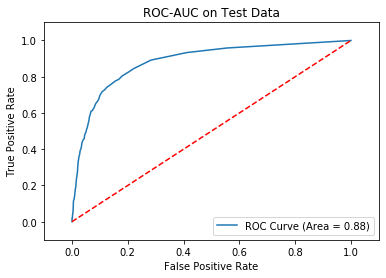

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Gradient Boosting

 Confusion Matrix


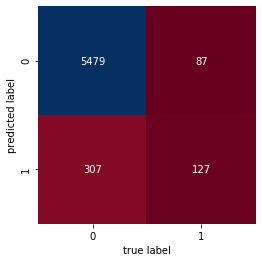


 Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5566
           1       0.59      0.29      0.39       434

    accuracy                           0.93      6000
   macro avg       0.77      0.64      0.68      6000
weighted avg       0.92      0.93      0.92      6000

Accuracy:  0.9343333333333333
Precision Score:  0.5934579439252337
Recall Score:  0.2926267281105991
F1 Score:  0.39197530864197533
AUC:  0.9013387320317067


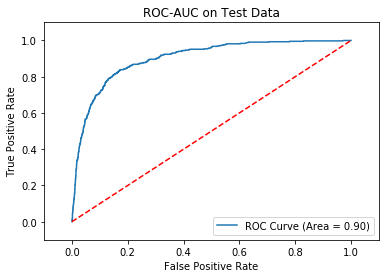

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------


In [26]:
model_data(X_train, X_test, Y_train, Y_test)

## Naive bayes threw a value error, negative values passed as input - how to tackle this? Balance is negative hence the error

#### Running model using all the features

In [28]:
d_all = d
d_all.shape

(40000, 14)

In [33]:
d_all['y'] = d_all.y.map(dict(yes=1, no=0))

In [38]:
d_all.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [44]:
d_all.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y             int64
dtype: object

In [45]:
#creating dummy variables for categorical variables
cols_to_transform = ['job', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month']

In [47]:
df_with_dummies = pd.get_dummies(data = d_all, columns = cols_to_transform )

In [48]:
df_with_dummies.head()

,age,balance,day,duration,campaign,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,2143,5,261,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,44,29,5,151,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,2,5,76,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1506,5,92,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,33,1,5,198,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [49]:
df_with_dummies.shape

(40000, 45)

In [51]:
df_with_dummies.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'y', 'job_admin',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct'],
      dtype='object')

In [52]:
Y = df_with_dummies['y']
X = df_with_dummies.drop('y', axis=1)
#train:test = 0.85:0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.85, random_state = 21, stratify=Y)
print("Train Data Dimensions : ", X_train.shape)
print("Test Data Dimensions : ", X_test.shape)

Train Data Dimensions :  (34000, 44)
Test Data Dimensions :  (6000, 44)



 Logistic Regression

 Confusion Matrix


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


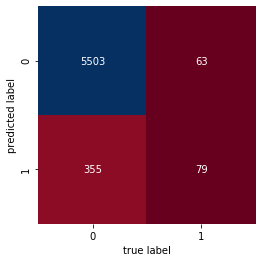


 Classification Report 

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      5566
           1       0.56      0.18      0.27       434

    accuracy                           0.93      6000
   macro avg       0.75      0.59      0.62      6000
weighted avg       0.91      0.93      0.91      6000

Accuracy:  0.9303333333333333
Precision Score:  0.5563380281690141
Recall Score:  0.18202764976958524
F1 Score:  0.2743055555555555
AUC:  0.8653145910572915


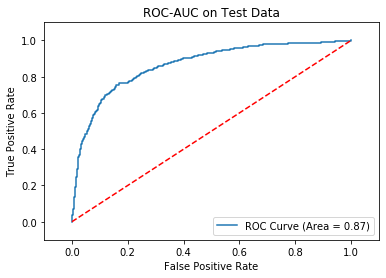

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Decision Tree

 Confusion Matrix


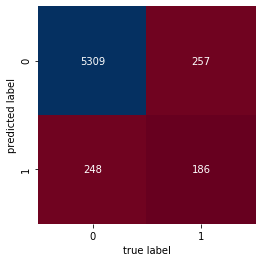


 Classification Report 

              precision    recall  f1-score   support

           0       0.96      0.95      0.95      5566
           1       0.42      0.43      0.42       434

    accuracy                           0.92      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.92      0.92      0.92      6000

Accuracy:  0.9158333333333334
Precision Score:  0.4198645598194131
Recall Score:  0.42857142857142855
F1 Score:  0.4241733181299886
AUC:  0.6911991170884452


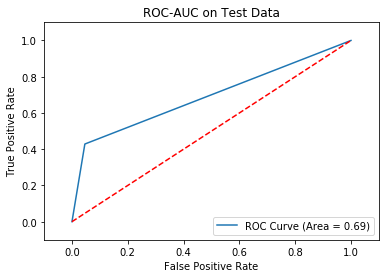

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Random Forest

 Confusion Matrix


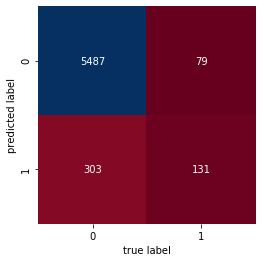


 Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5566
           1       0.62      0.30      0.41       434

    accuracy                           0.94      6000
   macro avg       0.79      0.64      0.69      6000
weighted avg       0.92      0.94      0.93      6000

Accuracy:  0.9363333333333334
Precision Score:  0.6238095238095238
Recall Score:  0.30184331797235026
F1 Score:  0.40683229813664595
AUC:  0.9333583508165938


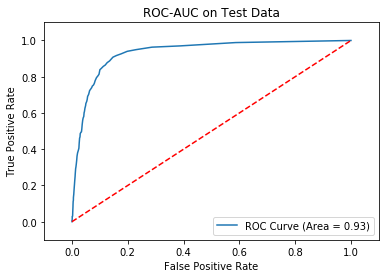

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Gradient Boosting

 Confusion Matrix


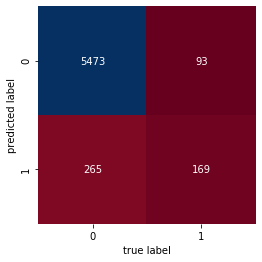


 Classification Report 

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5566
           1       0.65      0.39      0.49       434

    accuracy                           0.94      6000
   macro avg       0.80      0.69      0.73      6000
weighted avg       0.93      0.94      0.93      6000

Accuracy:  0.9403333333333334
Precision Score:  0.6450381679389313
Recall Score:  0.38940092165898615
F1 Score:  0.48563218390804597
AUC:  0.9451823199113776


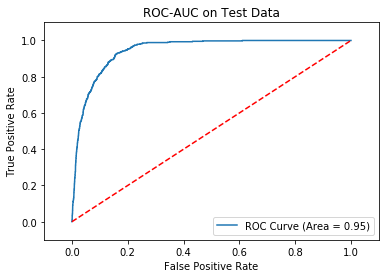

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------


In [53]:
model_data(X_train, X_test, Y_train, Y_test)

In [54]:
#Let's run the models again, this time standardizing the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df_with_dummies) 
df_with_dummies.loc[:,:] = scaled_values

In [55]:
df_with_dummies.head()

,age,balance,day,duration,campaign,y,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,0.513158,0.092259,0.133333,0.053070,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.328947,0.073067,0.133333,0.030704,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.184211,0.072822,0.133333,0.015453,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.368421,0.086476,0.133333,0.018707,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.184211,0.072812,0.133333,0.040260,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [56]:
Y = df_with_dummies['y']
X = df_with_dummies.drop('y', axis=1)
#train:test = 0.85:0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.85, random_state = 21, stratify=Y)
print("Train Data Dimensions : ", X_train.shape)
print("Test Data Dimensions : ", X_test.shape)

Train Data Dimensions :  (34000, 44)
Test Data Dimensions :  (6000, 44)



 Logistic Regression

 Confusion Matrix


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


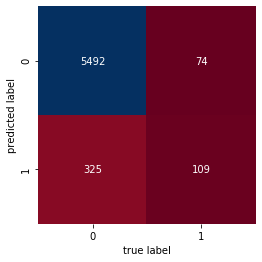


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      5566
         1.0       0.60      0.25      0.35       434

    accuracy                           0.93      6000
   macro avg       0.77      0.62      0.66      6000
weighted avg       0.92      0.93      0.92      6000

Accuracy:  0.9335
Precision Score:  0.5956284153005464
Recall Score:  0.2511520737327189
F1 Score:  0.35332252836304706
AUC:  0.9227158472026508


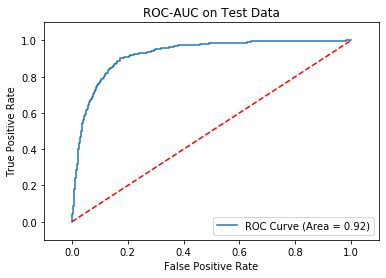

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Decision Tree

 Confusion Matrix


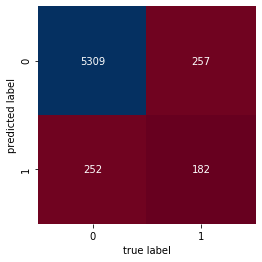


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      5566
         1.0       0.41      0.42      0.42       434

    accuracy                           0.92      6000
   macro avg       0.68      0.69      0.69      6000
weighted avg       0.92      0.92      0.92      6000

Accuracy:  0.9151666666666667
Precision Score:  0.4145785876993166
Recall Score:  0.41935483870967744
F1 Score:  0.41695303550973656
AUC:  0.6865908221575696


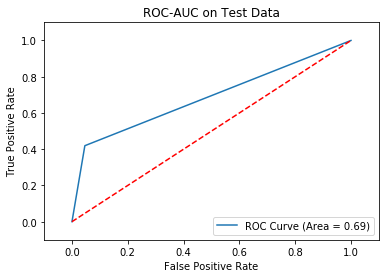

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Random Forest

 Confusion Matrix


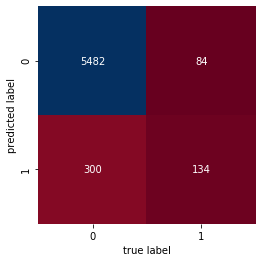


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      5566
         1.0       0.61      0.31      0.41       434

    accuracy                           0.94      6000
   macro avg       0.78      0.65      0.69      6000
weighted avg       0.92      0.94      0.93      6000

Accuracy:  0.936
Precision Score:  0.6146788990825688
Recall Score:  0.3087557603686636
F1 Score:  0.41104294478527603
AUC:  0.9332753501757709


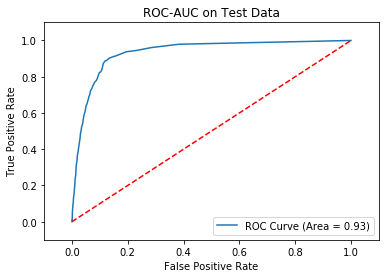

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------

 Gradient Boosting

 Confusion Matrix


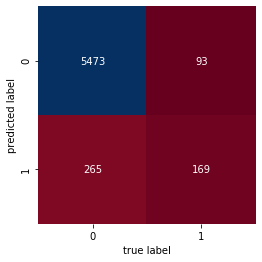


 Classification Report 

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      5566
         1.0       0.65      0.39      0.49       434

    accuracy                           0.94      6000
   macro avg       0.80      0.69      0.73      6000
weighted avg       0.93      0.94      0.93      6000

Accuracy:  0.9403333333333334
Precision Score:  0.6450381679389313
Recall Score:  0.38940092165898615
F1 Score:  0.48563218390804597
AUC:  0.9451649332434746


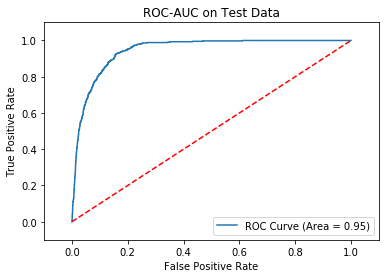

----------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------


In [57]:
model_data(X_train, X_test, Y_train, Y_test)

## Noticing no change in AUC occuring due to scaling features for tree based models 